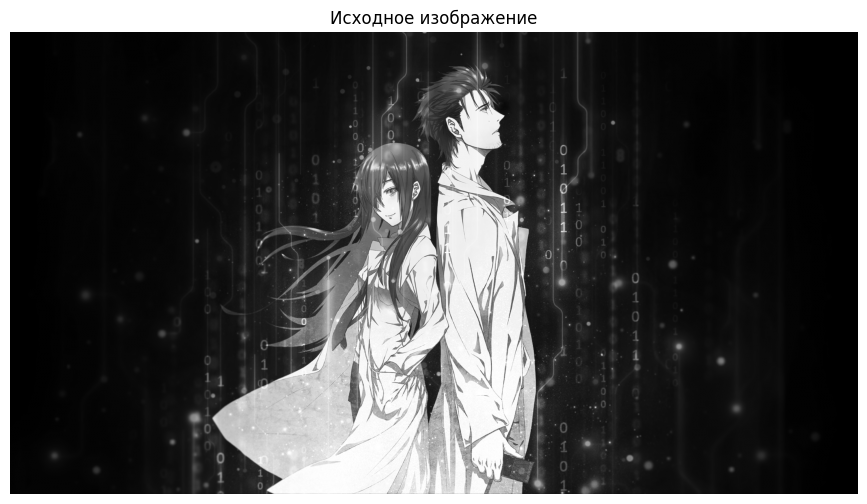

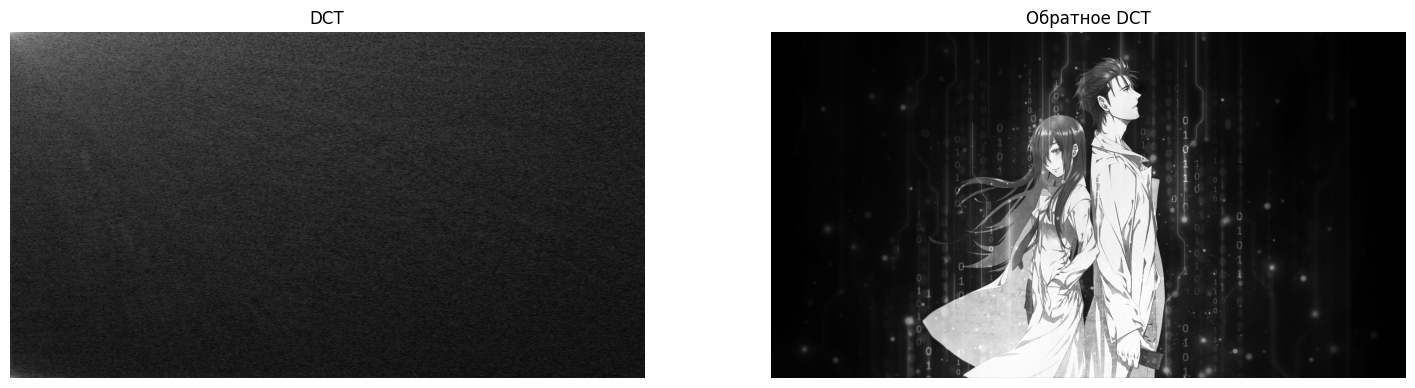

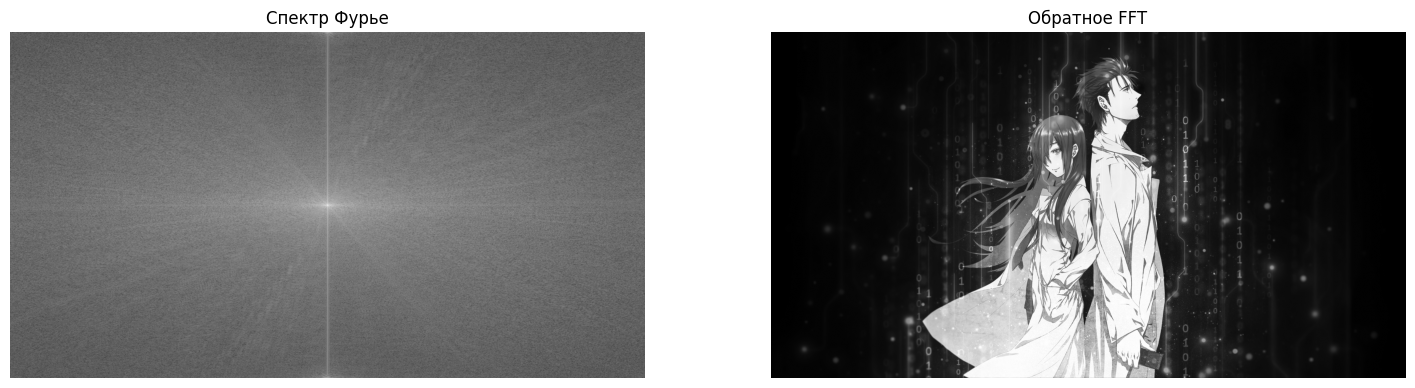

Корреляция DCT: 1.0000
Корреляция FFT: 1.0000
Изображение после DCT ближе к оригиналу


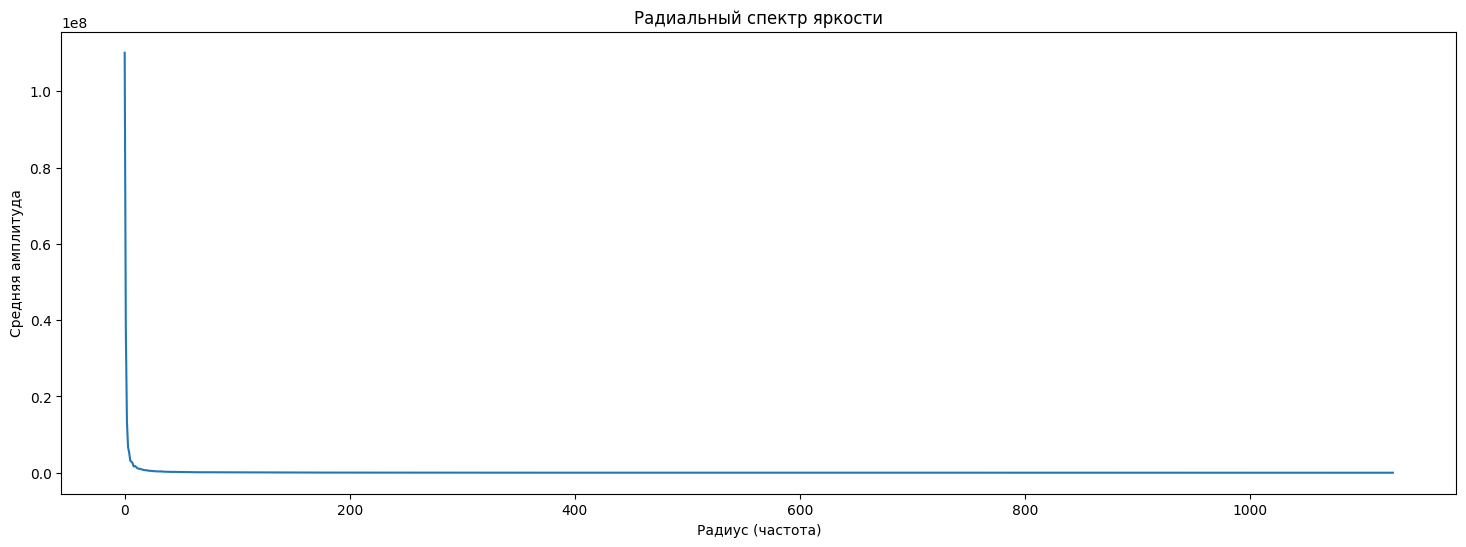

In [8]:
# %matplotlib ipympl

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy.ndimage import median_filter, rank_filter
from scipy.signal import wiener
from skimage.morphology import square
from skimage.util import random_noise

# ===========================
# КОНСТАНТЫ
# ===========================
# Шум
NOISE_GAUSSIAN_STD = 20       # стандартное отклонение гауссова шума
NOISE_SP_AMOUNT = 0.05        # доля пикселей для salt & pepper
NOISE_MULTIPLIER_STD = 0.2    # интенсивность мультипликативного шума

# Размеры масок фильтров
MASK_SIZES = [3, 5, 7]

# Размеры графиков
FIGSIZE_SINGLE = (18, 6)       # одиночное изображение
FIGSIZE_DOUBLE = (18, 6)      # два изображения рядом
FIGSIZE_TRIPLE = (18, 6)      # три изображения рядом
FIGSIZE_CORR = (18, 6)        # график корреляции

# ===========================
# ФУНКЦИИ
# ===========================
def normalize_image(img):
    """Масштабирование изображения в диапазон 0-255"""
    img = img - img.min()
    img = img / img.max()
    img = (img * 255).astype(np.uint8)
    return img

def correlation_coefficient(img1, img2):
    """Коэффициент корреляции между двумя изображениями"""
    img1 = img1.flatten()
    img2 = img2.flatten()
    return np.corrcoef(img1, img2)[0,1]

# ===========================
# 1. Загрузка изображения
# ===========================
img = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)
img = normalize_image(img)

plt.figure(figsize=FIGSIZE_SINGLE)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

# ===========================
# 2. DCT / IDCT
# ===========================
dct_img = dct(dct(img.T, norm='ortho').T, norm='ortho')
idct_img = idct(idct(dct_img.T, norm='ortho').T, norm='ortho')
idct_img = normalize_image(idct_img)

plt.figure(figsize=FIGSIZE_DOUBLE)
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(dct_img)+1), cmap='gray')
plt.title('DCT')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(idct_img, cmap='gray')
plt.title('Обратное DCT')
plt.axis('off')
plt.show()

# ===========================
# 3. FFT / IFFT
# ===========================
fft_img = np.fft.fft2(img)
fft_shift = np.fft.fftshift(fft_img)
ifft_img = np.fft.ifft2(fft_img).real
ifft_img = normalize_image(ifft_img)
magnitude_spectrum = 20*np.log(np.abs(fft_shift)+1)

plt.figure(figsize=FIGSIZE_DOUBLE)
plt.subplot(1,2,1)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Спектр Фурье')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ifft_img, cmap='gray')
plt.title('Обратное FFT')
plt.axis('off')
plt.show()

# ===========================
# 4. Коэффициент корреляции
# ===========================
corr_dct = correlation_coefficient(img, idct_img)
corr_fft = correlation_coefficient(img, ifft_img)
print(f"Корреляция DCT: {corr_dct:.4f}")
print(f"Корреляция FFT: {corr_fft:.4f}")

if corr_dct > corr_fft:
    print("Изображение после DCT ближе к оригиналу")
else:
    print("Изображение после FFT ближе к оригиналу")

# ===========================
# 6. Радиальный спектр яркости
# ===========================
rows, cols = img.shape
y = np.arange(-rows//2, rows//2)
x = np.arange(-cols//2, cols//2)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
fft_shift = np.fft.fftshift(fft_img)
magnitude = np.abs(fft_shift)

radii = R.astype(int)
radial_profile = np.bincount(radii.ravel(), magnitude.ravel()) / np.bincount(radii.ravel())
plt.figure(figsize=FIGSIZE_SINGLE)
plt.plot(radial_profile)
plt.title("Радиальный спектр яркости")
plt.xlabel("Радиус (частота)")
plt.ylabel("Средняя амплитуда")
plt.show()


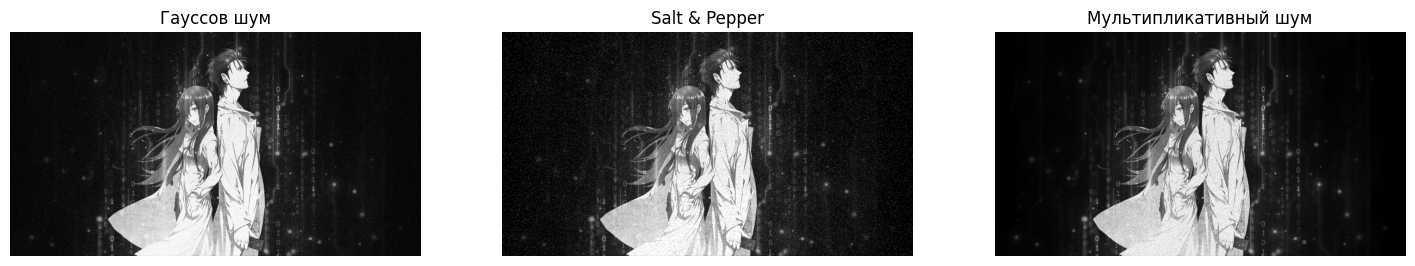

/tmp/ipykernel_205785/2930525201.py:36: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  rank_img = rank_filter(multiplicative_noise.astype(np.uint8), footprint=square(size), rank=(size*size)//2)


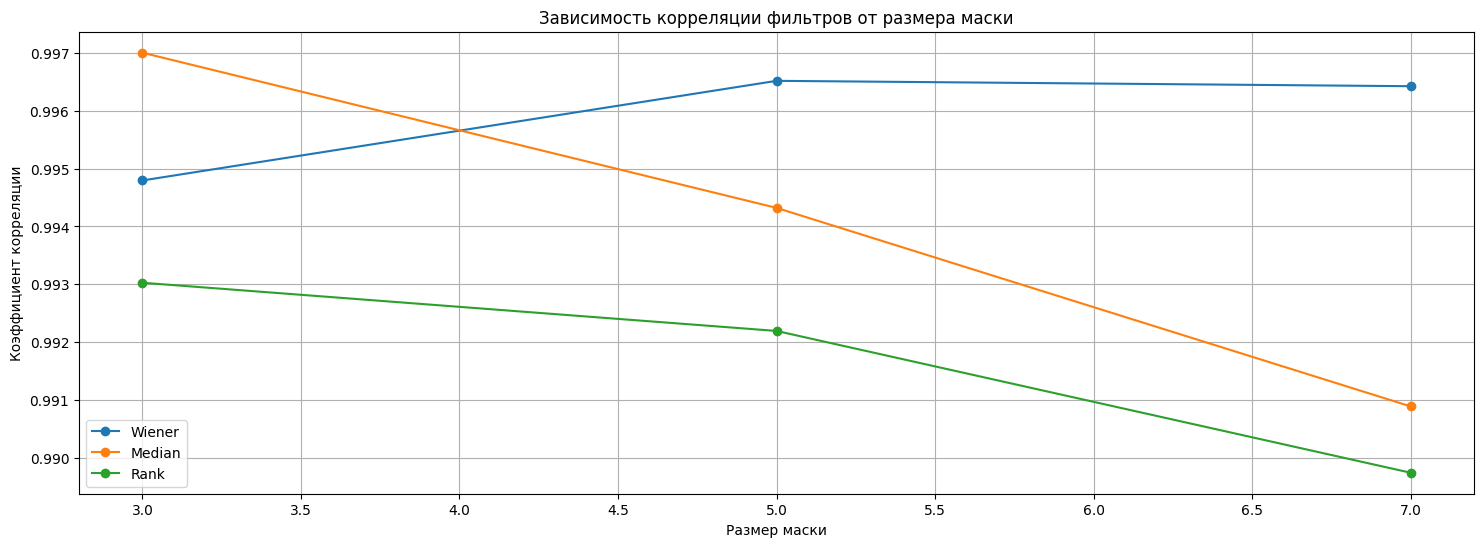

In [ ]:
# ===========================
# 7. Добавление шумов (одиночные выводы)
# ===========================
# Гауссов шум
gaussian_noise = img + np.random.normal(0, NOISE_GAUSSIAN_STD, img.shape)
gaussian_noise = np.clip(gaussian_noise, 0, 255)
plt.figure(figsize=FIGSIZE_SINGLE)
plt.imshow(gaussian_noise, cmap='gray')
plt.title('Гауссов шум')
plt.axis('off')
plt.show()

# Salt & Pepper
sp_noise = random_noise(img, mode='s&p', amount=NOISE_SP_AMOUNT)
sp_noise = (sp_noise*255).astype(np.uint8)
plt.figure(figsize=FIGSIZE_SINGLE)
plt.imshow(sp_noise, cmap='gray')
plt.title('Salt & Pepper')
plt.axis('off')
plt.show()

# Мультипликативный шум
multiplicative_noise = img * (1 + NOISE_MULTIPLIER_STD*np.random.randn(*img.shape))
multiplicative_noise = np.clip(multiplicative_noise, 0, 255)
plt.figure(figsize=FIGSIZE_SINGLE)
plt.imshow(multiplicative_noise, cmap='gray')
plt.title('Мультипликативный шум')
plt.axis('off')
plt.show()

# ===========================
# 8-9. Фильтрация (одиночные выводы)
# ===========================
filters_results = {}

for size in MASK_SIZES:
    # Винеровская фильтрация (для гауссового шума)
    wiener_img = normalize_image(wiener(gaussian_noise, (size, size)))
    plt.figure(figsize=FIGSIZE_SINGLE)
    plt.imshow(wiener_img, cmap='gray')
    plt.title(f'Винер фильтр, размер маски {size}')
    plt.axis('off')
    plt.show()
    
    # Медианная фильтрация (для Salt & Pepper)
    median_img = normalize_image(median_filter(sp_noise, size=size))
    plt.figure(figsize=FIGSIZE_SINGLE)
    plt.imshow(median_img, cmap='gray')
    plt.title(f'Медианный фильтр, размер маски {size}')
    plt.axis('off')
    plt.show()
    
    # Ранговая фильтрация (для мультипликативного шума)
    rank_img = normalize_image(rank_filter(multiplicative_noise.astype(np.uint8),
                                           footprint=square(size),
                                           rank=(size*size)//2))
    plt.figure(figsize=FIGSIZE_SINGLE)
    plt.imshow(rank_img, cmap='gray')
    plt.title(f'Ранговый фильтр, размер маски {size}')
    plt.axis('off')
    plt.show()
    
    filters_results[size] = {
        'Wiener': wiener_img,
        'Median': median_img,
        'Rank': rank_img
    }

# ===========================
# 10. График коэффициентов корреляции
# ===========================
plt.figure(figsize=FIGSIZE_CORR)

for filter_name in ['Wiener','Median','Rank']:
    corrs = [correlation_coefficient(img, filters_results[size][filter_name]) for size in MASK_SIZES]
    plt.plot(MASK_SIZES, corrs, marker='o', label=filter_name)

plt.title("Зависимость корреляции фильтров от размера маски")
plt.xlabel("Размер маски")
plt.ylabel("Коэффициент корреляции")
plt.legend()
plt.grid(True)
plt.show()
